In [1]:
import numpy as np
import matplotlib.pyplot as plt

Create a database which can be accessed by all the nodes

In [2]:
DB = {} #database
B = 20 #MHz; bandwidth of each block

M = 10 #number of f-blocks
density = 125e-6
N = 25 #number of nodes

area = N/density
L = np.sqrt(area)
d_max = 300 #m; max distance between two neighbors
epsilon = -1e-5
alpha = 2.5 #pathloss exponent
noise = 1e-5 #W; Rx noise
P = 1 #W; Tx power of each access point
R = 50.0 #m; range of an access point
N_ITER = 1000
turn_count = 100

Importing Libraries

Channel Gain matrix

In [3]:
H = np.random.exponential(1, (N, N))

for i in range(N):
  for j in range(N):
    H[i][j] = H[j][i] 

Define a class for nodes

In [4]:
class Node:
  def __init__(self, x, y, ID):
    self.x = x
    self.y = y
    self.ID = str(ID)
    self.neighbors = {}
    self.neighbor_nodes = []
    self.BSI = None
    self.datarate_min = None

  def init_BSI(self):
    self.BSI = np.ones(M, dtype='float64')

  def publish_BSI(self):
    DB[self.ID] = self.BSI

  def add_neighbor(self, ID, distance):
    self.neighbors[str(ID)] = distance
    self.neighbor_nodes.append(ID)

  def update_BSI(self):
    if len(self.neighbors) > 0:
        # collect the BSI of neighbors and scale them by 1/distance^2
        score = np.zeros(M, dtype='float64')
        for nn in self.neighbor_nodes:
          # suggestion from the neighbours
          this_BSI = -np.power(self.neighbors[str(nn)], -alpha)*DB[str(nn)]
          score = score + this_BSI
        # print(score)


        # update the BSI by occupying the positive scores
        not_chosen = []

        # social learning
        for m in range(M):
          if score[m] > epsilon:
            self.BSI[m] = 1.0
          else:
            self.BSI[m] = -1.0
            not_chosen.append(m)

        # check if the datarate requirements are satisfied:
        # by calculating the performance in each f-block
        self.publish_BSI()
        datarate_achieved = get_datarate(int(self.ID))

        # self learning
        while len(not_chosen) > 2: 
          if datarate_achieved >= self.min_datarate:
            break

          k_max = not_chosen[np.random.randint(len(not_chosen))]
          self.BSI[k_max] = 1.0
          not_chosen.remove(k_max)

          self.publish_BSI()
          datarate_achieved = get_datarate(int(self.ID))

    self.publish_BSI()

Create N nodes in a region of size 2Lx2L

In [5]:
node_list = []

for i in range(N):
  x = np.random.uniform(-L/2, L/2)
  y = np.random.uniform(-L/2, L/2)
  node_list.append(Node(x, y, i))

Neighbors

In [6]:
def distance(i, j):
  x_i = node_list[i].x
  y_i = node_list[i].y
  x_j = node_list[j].x
  y_j = node_list[j].y

  return np.sqrt( np.square(x_i-x_j) + np.square(y_i-y_j) )

for i in range(N):
  for j in range(i+1, N):
    d = distance(i, j)
    if d < d_max:
      node_list[i].add_neighbor(j, d)
      node_list[j].add_neighbor(i, d)


Visualize nodes

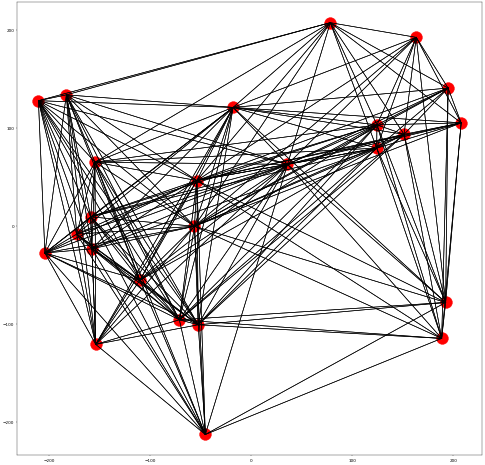

In [26]:
plt.figure(figsize=(20, 20), dpi=30)
for i in range(N):
  for j in node_list[i].neighbor_nodes:
    plt.plot([node_list[i].x, node_list[j].x], [node_list[i].y, node_list[j].y], color='black')

for i in range(N):
  plt.scatter(node_list[i].x, node_list[i].y, color='red', s=800)

plt.show()

### Save Coordinates

In [8]:
# X_Y_data = []
# for i in range(N):
#   X_Y_data.append( [node_list[i].x, node_list[i].y] )

# np.savetxt("XY_125.csv", X_Y_data, delimiter=",")

Initialize BSI for all nodes

In [9]:
for i in range(N):
  node_list[i].init_BSI()
  node_list[i].publish_BSI()

Performance Evaluation

In [11]:
def get_datarates(opt):
  datarate = np.zeros(N, dtype='float64')
  SE = np.zeros(N, dtype='float64') # average spectral efficiency
  n_iter = 1000

  for iter in range(n_iter):
    H = np.random.exponential(1, (N, N))

    for i in range(N):
      for j in range(N):
        H[i][j] = H[j][i] 
    
    for i in range(N):
      BSI_i = node_list[i].BSI
      c = 0
      for m in range(M):
        if BSI_i[m] > 0:
          I_power = 0.0
          for j in range(N):
            if j!=i:
              if node_list[j].BSI[m] > 0:
                d = distance(i, j)
                I_power += H[i][j]*P*np.power(d, -alpha)
          
          SINR = H[i][i]*P*np.power(R, -alpha)/(noise + I_power)
          datarate[i] += B*np.log2(1 + SINR) 
          c += 1
          SE[i] += datarate[i]/(c*B)
    

  if opt:
    return datarate/n_iter
  return SE/n_iter

def get_datarate(i):
  datarate = 0.0
  BSI_i = node_list[i].BSI
  for m in range(M):
    if BSI_i[m] > 0:
      I_power = 0.0
      for j in range(N):
        if j!=i:
          if node_list[j].BSI[m] > 0:
            d = distance(i, j)
            I_power += P*np.power(d, -alpha)
      SINR = P*np.power(R, -alpha)/(noise + I_power)
      datarate += B*np.log2(1 + SINR)

  return datarate


def get_datarates_all(opt):
  n_iter = N_ITER
  datarate = np.zeros((N, n_iter), dtype='float64')
  SE = np.zeros((N, n_iter), dtype='float64')

  for iter in range(n_iter):
    H = np.random.exponential(1, (N, N))

    for i in range(N):
      for j in range(N):
        H[i][j] = H[j][i] 
    
    for i in range(N):
      BSI_i = node_list[i].BSI
      c = 0
      for m in range(M):
        if BSI_i[m] > 0:
          I_power = 0.0
          for j in range(N):
            if j!=i:
              if node_list[j].BSI[m] > 0:
                d = distance(i, j)
                I_power += H[i][j]*P*np.power(d, -alpha)
          
          SINR = H[i][i]*P*np.power(R, -alpha)/(noise + I_power)
          datarate[i][iter] += B*np.log2(1 + SINR)
          c+= 1 
      SE[i][iter] += datarate[i][iter]/(c*B)
    
  if opt:
    return SE

  return datarate


Set minimum datarate values for each node

In [12]:
for i in range(N):
  node_list[i].min_datarate = get_datarate(i)

Create a sequence (Poisson clock)

In [13]:
poisson_triggers = list(np.random.randint(N, size=10000))

In [14]:
D_init_hist = get_datarates_all(0)
SE_init_hist = get_datarates_all(1)

In [15]:
for i in poisson_triggers:
  node_list[i].update_BSI()

In [16]:
# DB

In [17]:
D_final_hist = get_datarates_all(0)
SE_final_hist = get_datarates_all(1)

### Save data

In [ ]:
# np.savetxt("D_init_"+str(N)+".csv", D_init_hist, delimiter=",")
# np.savetxt("D_final_"+str(N)+".csv", D_final_hist, delimiter=",")
# np.savetxt("SE_init_"+str(N)+".csv", SE_init_hist, delimiter=",")
# np.savetxt("SE_final_"+str(N)+".csv", SE_final_hist, delimiter=",")

Plots

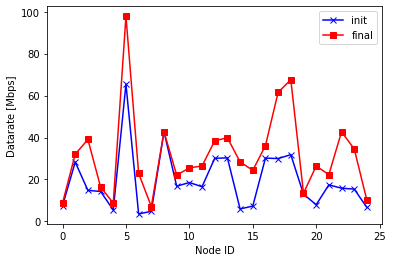

In [21]:
plt.plot(list(range(N)), np.mean(D_init_hist, axis=1), color='blue', label='init', marker='x')
plt.plot(list(range(N)), np.mean(D_final_hist, axis=1), color='red', label='final', marker='s')
plt.xlabel('Node ID')
plt.ylabel('Datarate [Mbps]')
plt.legend()
plt.show()

In [25]:
# Jain's Fairness Index

J_fair_init = np.square(np.sum(np.mean(D_init_hist, axis=1)))/(N*np.sum(np.square(np.mean(D_init_hist, axis=1))))
J_fair_final = np.square(np.sum(np.mean(D_final_hist, axis=1)))/(N*np.sum(np.square(np.mean(D_final_hist, axis=1))))

print(J_fair_init, J_fair_final)

0.652496251173876 0.7147631114776263


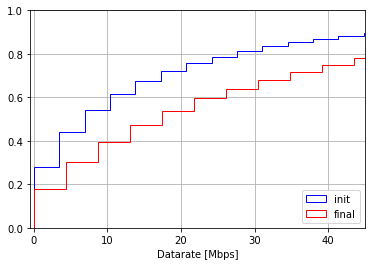

In [22]:
plt.hist(np.reshape(D_init_hist, (N*N_ITER, 1)), bins=100, density=True, cumulative=True, label='init', histtype='step', color='blue')
plt.hist(np.reshape(D_final_hist, (N*N_ITER, 1)), bins=100, density=True, cumulative=True, label='final', histtype='step', color='red')
plt.xlabel('Datarate [Mbps]')
plt.legend(loc='lower right')
plt.xlim(-0.5, 45)
plt.ylim(0,1)
plt.grid()
plt.show()